In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Setup Environment

In [ ]:
import sys
import os
import shutil
import random
import numpy as np
import pandas as pd

# Setting up data directories
dst_dir = '/content/drive/MyDrive/Colab Notebooks/AI_Project/'
env_dir = '/content/drive/MyDrive/env_nlp'

path_dataset = dst_dir + 'LEVIR-CD/'
path_dataset_train = path_dataset + 'train/'
path_dataset_val = path_dataset + 'val/'
path_dataset_test = path_dataset + 'test/'
dir_struct = ['A', 'B', 'label']

modelname = 'siamesenet_train.pth'
model_path = os.path.join(dst_dir, modelname)
out_filename = 'siamesenet'
save_change_map_dir = os.path.join(dst_dir, 'changemaps/')
save_roc_dir = os.path.join(dst_dir,'roc')

In [ ]:
%cd $dst_dir

/content/drive/MyDrive/Colab Notebooks/AI_Project


In [ ]:
#if not os.path.lexists(dst_dir):
#    os.symlink(dst_dir, env_dir)

#if not os.path.lexists(project_dir):
#    os.symlink(project_dir, env_dir)

#sys.path.insert(0, env_dir)

In [ ]:
from fastai.vision.all import *
from fastai.data.external import *
from fastai.data.core import DataLoaders

In [ ]:
import PIL
from PIL import Image
import torch

import torch.nn as nn
import torch.nn.init as init
from torch import autograd
import torchvision
import torchvision.transforms as T
from torchvision import datasets, models, transforms, utils
from torch.autograd import Variable
from torch import optim
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
import cdutils
from cdutils import open_image, open_mask, visualize_image

In [ ]:
# imports from scene detection git repo
import metric as mc
#import fcn32s_tiny as modelsfcn32s_tiny

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
train_on_gpu = torch.cuda.is_available()
print(train_on_gpu)

False


## Functions

In [268]:
def get_changemap_example(img1, img2, target, map_type = 'conv1'):
 
  out_conv1, out_fc, out_embedding = model(img1, img2)

  out_conv1_t0, out_conv1_t1 = out_conv1
  out_fc_t0, out_fc_t1 = out_fc
  out_embedding_t0, out_embedding_t1 = out_embedding

  if map_type == 'conv1':
    output_t0 = out_conv1_t0
    output_t1 = out_conv1_t1
  elif map_type == 'fc':
    output_t0 = out_fc_t0
    output_t1 = out_fc_t1
  elif map_type == 'embedding':
    output_t0 = out_embedding_t0
    output_t1 = out_embedding_t1
     

  TRANSFROM_SCALES= (256, 256)
  interp = nn.Upsample(size=[TRANSFROM_SCALES[1],TRANSFROM_SCALES[0]], mode='bilinear')
  n, c, h, w = output_t0.data.shape

  out_vec_t0 = torch.transpose(output_t0.view(c, h * w), 1, 0)
  out_vec_t1 = torch.transpose(output_t1.view(c, h * w), 1, 0)

  distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=2)

  similar_distance_map = distance.view(h,w).data.cpu().numpy()
  similar_distance_map_rz = interp(Variable(torch.from_numpy(similar_distance_map[np.newaxis, np.newaxis, :])))
  similar_dis_map_colorize = cv2.applyColorMap(np.uint8(255 * similar_distance_map_rz.data.cpu().numpy()[0][0]), cv2.COLORMAP_JET)

  return similar_dis_map_colorize 

def plot_changemap(processed):
  # input is a 3D image
  transform = T.ToPILImage()
  # Plot
  fig = plt.figure(figsize=(30, 50))
  for i in range(len(processed)):
    a = fig.add_subplot(5, 4, i+1)
    imgplot = plt.imshow(transform(processed[i]))
    a.axis("off")
  return

## Create Dataset and DataLoaders

In [ ]:
#
# Class to create Image pairs and corresponding label
#

class SiameseDataset(torch.utils.data.Dataset):
  def __init__(self, data_dir, dir_struct, filenames):
    self.data_dir = data_dir
    self.dir_struct = dir_struct
    self.filenames = filenames
    
    
  def __getitem__(self, i):
  
    file1 = os.path.join(self.data_dir, self.dir_struct[0], self.filenames[i])
    file2 = os.path.join(self.data_dir, self.dir_struct[1], self.filenames[i])
    label = os.path.join(self.data_dir, self.dir_struct[2], self.filenames[i])   
     
    img1 = open_image(Path(file1))
    img2 = open_image(Path(file2))
    label = open_mask(Path(label))

    return img1, img2, label

  def __len__(self):
    return len(self.filenames)

In [ ]:
train_files = get_image_files(path_dataset_train)
val_files = get_image_files(path_dataset_val)
test_files = get_image_files(path_dataset_test)

train_filenm = list(set([a.parts[9] for a in train_files]))
val_filenm = list(set([a.parts[9] for a in val_files]))
test_filenm = list(set([a.parts[9] for a in test_files]))

# Create Datasets
train_dataset = SiameseDataset(data_dir = path_dataset_train, dir_struct = dir_struct, filenames = train_filenm)
valid_dataset = SiameseDataset(data_dir = path_dataset_val, dir_struct = dir_struct, filenames = val_filenm)
test_dataset = SiameseDataset(data_dir = path_dataset_test, dir_struct = dir_struct, filenames = test_filenm)
print(f'Dataset: Train: {len(train_dataset)} Val: {len(valid_dataset)} Test: {len(test_dataset)}')

# define dataloader parameters
batch_size = 1 # change to 16 when ready
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
print(f'Loader Sizes: Train {len(train_loader)}  Val: {len(valid_loader)}  Test: {len(test_loader)}')

Dataset: Train: 445 Val: 64 Test: 128
Loader Sizes: Train 445  Val: 64  Test: 128


In [ ]:
#vgg16 = models.vgg16(pretrained=True)

## Examine Images

In [ ]:
# Sample Original Image -- comment after test
ex = os.path.join(path_dataset_train, dir_struct[0], train_filenm[120])
exmask = os.path.join(path_dataset_train, dir_struct[2], train_filenm[120])
im_orig = mpimg.imread(ex)
msk_orig = mpimg.imread(exmask)
print(f'Original Image Shape: {im_orig.shape} Mask shape: {msk_orig.shape}') 

Original Image Shape: (1024, 1024, 3) Mask shape: (1024, 1024)


In [ ]:
## comment after testing
#
# Example to check processed dataset
#
#exd1 = os.path.join(path_dataset_train, dir_struct[0], train_filenm[10])
#exd2 = os.path.join(path_dataset_train, dir_struct[1], train_filenm[10])
#exlabel = os.path.join(path_dataset_train, dir_struct[2], train_filenm[10])
# convert to tensor
#eximg1 = open_image(Path(exd1))
#eximg2 = open_image(Path(exd2))
#exlabelimg = open_mask(Path(exlabel))
#print(f'RESIZED Image Shape: {eximg1.shape} RESIZED 3-D Mask shape: {exlabelimg.shape}') 
#visualize_image([eximg1, eximg2, exlabelimg])

## Modified model from paper

In [ ]:
class SiameseCNN(nn.Module):
  def __init__(self):

    super(SiameseCNN, self).__init__()
    self.conv1 = nn.Sequential(
        nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,padding=1),
        nn.ReLU(inplace=True),
        #nn.Sigmoid()
        #nn.MaxPool2d(kernel_size=3,stride=2,padding=1,ceil_mode=True)
    )        
    self.embedding_layer = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, dilation=2, padding=2)
    self.fc = nn.Softmax2d()


  def forward(self,x):
      #print("Input shape", x.shape)
      x = self.conv1(x)
      conv1 = x
      #print("After Conv1 shape", x.shape)
      x = self.embedding_layer(x)
      embedding = x
      #print("After Embedding shape", x.shape)
      embedding_feature = self.fc(x)
      return conv1, embedding, embedding_feature


class SiameseNet(nn.Module):
    def __init__(self):
        super(SiameseNet, self).__init__()
        self.CNN = SiameseCNN()

    def forward(self, t0, t1):
        out_t0_conv1, out_t0_embedding, out_t0_fc = self.CNN(t0)
        out_t1_conv1, out_t1_embedding, out_t1_fc = self.CNN(t1)
        return [out_t0_conv1, out_t1_conv1], [out_t0_embedding, out_t1_embedding], [out_t0_fc, out_t1_fc]
    
    
    def init_parameters_vgg16(self,pretrain_vgg16):

    ##### init parameter using pretrain vgg16 model ###########
        conv_blocks = [self.CNN.conv1]

        ranges = [[0, 4]]
        features = list(pretrain_vgg16.features.children())

        for idx, conv_block in enumerate(conv_blocks):
            for l1, l2 in zip(features[ranges[idx][0]:ranges[idx][1]], conv_block):
                if isinstance(l1, nn.Conv2d) and isinstance(l2, nn.Conv2d):
                    #print(idx, l1, l2)
                    assert l1.weight.size() == l2.weight.size()
                    assert l1.bias.size() == l2.bias.size()
                    l2.weight.data = l1.weight.data
                    l2.bias.data = l1.bias.data

        init.kaiming_uniform_(self.CNN.embedding_layer.weight.data, mode='fan_in')
        init.constant_(self.CNN.embedding_layer.bias.data, 0)

In [ ]:
model = SiameseNet()
print(model)

SiameseNet(
  (CNN): SiameseCNN(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
    )
    (embedding_layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2), dilation=(2, 2))
    (fc): Softmax2d()
  )
)


In [ ]:
# Xavier Weights Initialization
def init_weights(m):
  if isinstance(m, nn.Conv2d):
    torch.nn.init.xavier_normal_(m.weight)
model = model.apply(init_weights)

## Paper model

In [ ]:
#model = modelsfcn32s_tiny.SiameseNet(distance_flag='softmax')
#print(model)

In [ ]:
#model.init_parameters(vgg16)

/content/drive/MyDrive/Colab Notebooks/AI_Project/fcn32s_tiny.py:102: UserWarning: nn.init.kaiming_uniform is now deprecated in favor of nn.init.kaiming_uniform_.
  init.kaiming_uniform(self.CNN.embedding_layer.weight.data, mode='fan_in')
/content/drive/MyDrive/Colab Notebooks/AI_Project/fcn32s_tiny.py:103: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(self.CNN.embedding_layer.bias.data, 0)


In [ ]:
#print(model)

## View model layer weight info

In [ ]:
# get all the model children as list
model_children = list(model.children())
layers = list(model_children[0].children())

In [ ]:
#
# Get Convolutional Layers and Model Weights  -- not necessary to run after testing
#

def get_layer_info(layers):
  counter = 0
  model_weights = []
  conv_layers = []
  for i, layer in enumerate(layers):
    if type(layer) == nn.Sequential:
     for j, ll in enumerate(layer):
       if type(ll) == nn.Conv2d:
         conv_layers.append(ll)
         model_weights.append(ll.weight)
         counter += 1
    elif type(layer) == nn.Conv2d: # non sequential layer
      conv_layers.append(layer)
      model_weights.append(layer.weight)
      counter += 1
  print(f"Total Convolutional Layers: {counter}")
  return conv_layers, model_weights    

In [ ]:
conv_layers, model_weights = get_layer_info(layers)
#conv_layers
#print(model_weights)

Total Convolutional Layers: 3


## DeepLab Models

In [ ]:
### From Scene detection 
#import layer.function as fun
#import layer.loss as ls
#from model.siameseNet import deeplab_v2 as models
#model = models.SiameseNet(norm_flag='l2')

In [ ]:
###
# Pretrained Model: DeepLabv2
###
#model_deeplabv2 = torch.hub.load("kazuto1011/deeplab-pytorch", "deeplabv2_resnet101", pretrained='cocostuff164k', n_classes=182)

In [ ]:
###
# Pretrained Model: DeepLabv3
###
#model_deeplabv3 = torch.hub.load('pytorch/vision:v0.10.0', 'deeplabv3_resnet50', pretrained=True)

In [ ]:
## Save Model weights
#PRETRAIN_MODEL_PATH = os.path.join(dst_dir,'deeplabv3_pretrain.pth')
#torch.save(model_deeplabv3.state_dict(), PRETRAIN_MODEL_PATH)
#model.load_state_dict(torch.load(PRETRAIN_MODEL_PATH, map_location=torch.device('cpu')))

## Loss

In [ ]:
class ConstractiveLoss(nn.Module):

      def __init__(self):
        super(ConstractiveLoss, self).__init__()

      def forward(self, output1, output2, label, device, margin=2.0):
        
        n = output1.size()[0]
        c = output1.size()[1]
        h = output1.size()[2]
        w = output1.size()[3]

        #print(n,c,h,w)

        #label_tensor = torch.from_numpy(np.array(label.data.cpu().numpy(),np.float32))
        #label_tensor = label_tensor.to(device)

        # Flatten image dimension to first dimension
        # For now removeving single batch dimension since pairwise does not do batchwise 
        output1_vec = torch.transpose(output1.view(n,c,h*w),2,0).squeeze() 
        output2_vec = torch.transpose(output2.view(n,c,h*w),2,0).squeeze() 
        label_vec = torch.transpose(label.view(n,1,h*w), 2, 0).squeeze(2) 

        #print(f'Model output shape: {output1_vec.shape} Target shape: {label_vec.shape}')

        euclidean_distance = F.pairwise_distance(output1_vec, output2_vec, p=2, keepdim = True) # Need to check that the channel dim is being used  
     
        #dist = (tensor1 - tensor2).pow(2).sum(3).sqrt() # sum along the channel dimension - for now model outputs 1 channel
        #euclidean_distance = ((output1_vec - output2_vec) + 0.02).pow(2).sqrt()
        #print(f'Distance shape: {euclidean_distance.shape}, label_vec shape: {label_vec.shape}')

        loss_contrastive = torch.sum((1-label_vec)*torch.pow(euclidean_distance,2 ) + label_vec * torch.pow(torch.clamp(margin - euclidean_distance, min=0.0),2))

        #pred = (margin < euclidean_distance).type(torch.float)

        return loss_contrastive

## checking training loop inputs

In [222]:
dataiter = iter(train_loader)
img1, img2, target = next(dataiter)
img1.shape, img2.shape, target.shape

(torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]),
 torch.Size([1, 256, 256]))

In [ ]:
#visualize_image([img1, img2, target])

In [ ]:
if train_on_gpu:
  img1, img2, target = img1.to(device), img2.to(device), target.to(device)

In [ ]:
if train_on_gpu:
  model = model.to(device)

In [ ]:
# One Image from batch
#X1_test = img1[0,:]
#X2_test = img2[0,:]
#Y_test = target[0,:]
#X1_test.shape, X2_test.shape, Y_test.shape
#visualize_image([X1_test, X2_test, Y_test])

In [ ]:
out_conv1, out_fc, out_embedding = model(img1, img2)

In [ ]:
out_conv1_t0, out_conv1_t1 = out_conv1
out_fc_t0, out_fc_t1 = out_fc
out_embedding_t0, out_embedding_t1 = out_embedding
out_conv1_t0.shape, out_fc_t0.shape, out_embedding_t0.shape, target.shape

(torch.Size([1, 32, 256, 256]),
 torch.Size([1, 32, 256, 256]),
 torch.Size([1, 32, 256, 256]),
 torch.Size([1, 256, 256]))

In [ ]:
criterion = ConstractiveLoss()
contractive_loss_conv1 = criterion(out_conv1_t0, out_conv1_t1, target, device)
contractive_loss_fc = criterion(out_fc_t0, out_fc_t1, target, device)
contractive_loss_embedding = criterion(out_embedding_t0, out_embedding_t1, target, device)
loss = contractive_loss_conv1 + contractive_loss_fc + contractive_loss_embedding
loss.item()
loss.backward()

In [ ]:
# conv layer
#conv_idx = 10
#out_conv1_t0_1 = out_conv1_t0[0,conv_idx,:,:]
#out_conv1_t1_1 = out_conv1_t1[0,conv_idx,:,:]
#out_conv1_t0_1.shape, out_conv1_t1_1.shape
#visualize_image([out_conv1_t0_1, out_conv1_t1_1])

In [ ]:
# FC layer
#conv_idx = 10
#out_fc_t0_1 = out_fc_t0[0,conv_idx,:,:]
#out_fc_t1_1 = out_fc_t1[0,conv_idx,:,:]
#out_fc_t0_1.shape, out_fc_t1_1.shape
#visualize_image([out_fc_t0_1, out_fc_t1_1])

In [ ]:
# embedding layer
#conv_idx = 31
#out_embedding_t0_1 = out_embedding_t0[0,conv_idx,:,:]
#out_embedding_t1_1 = out_embedding_t1[0,conv_idx,:,:]
#out_embedding_t0_1.shape, out_embedding_t1_1.shape
#visualize_image([out_embedding_t0_1, out_embedding_t1_1])

In [ ]:
with autograd.detect_anomaly():
  output1, output2 = model(img1, img2)
  output1.size(), output2.size()
  loss = criterion(output1, output2, target, device)
  loss.backward()

<ipython-input-18-3f3fcdb818a1>:1: UserWarning: Anomaly Detection has been enabled. This mode will increase the runtime and should only be enabled for debugging.
  with autograd.detect_anomaly():


In [ ]:
#plt.imshow(f[0,:].cpu().squeeze().detach().numpy())

In [ ]:
#plt.imshow(output2.squeeze().detach().numpy())

## Training/Validation Loop

In [ ]:
print(device)

cuda


In [ ]:
#model = model.apply(init_weights)

In [ ]:
def adjust_learning_rate(learning_rate, optimizer, step):
  lr = learning_rate * (0.1 ** (step // 20000)) 
  for param_group in optimizer.param_groups:
    param_group['lr'] = lr
  counter = 1
  if lr != learning_rate and counter == 1:
    print(f'learning_rate: {learning_rate} -> lr: {lr}')
    counter = 0 # so it prints only one time

In [ ]:
# Training Parameters

n_epochs = 100
valid_loss_min = np.Inf # track change in validation loss
criterion = ConstractiveLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.90, weight_decay=5e-5)

if train_on_gpu:
  model = model.to(device)

for epoch in range(1, n_epochs+1):

  train_loss = 0.0

  ###################
  # train the model #
  ###################

  # model by default is set to train

  for batch_i, batch in enumerate(train_loader):

    lr_step = epoch * len(train_loader) + batch_i
    adjust_learning_rate(1e-7, optimizer, lr_step)
    
    img1, img2, target = batch

    if train_on_gpu:
      img1, img2, target = img1.to(device), img2.to(device), target.to(device)

    out_conv1, out_fc, out_embedding = model(img1, img2)
    out_conv1_t0, out_conv1_t1 = out_conv1
    out_fc_t0, out_fc_t1 = out_fc
    out_embedding_t0, out_embedding_t1 = out_embedding

    loss_conv1 = criterion(out_conv1_t0, out_conv1_t1, target, device)
    loss_fc = criterion(out_fc_t0, out_fc_t1, target, device)
    loss_embedding = criterion(out_embedding_t0, out_embedding_t1, target, device)
    loss = loss_conv1 + loss_fc + loss_embedding

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    train_loss += loss.item()

    #if (batch_i) % 20 == 0:
    #  print(f'Epoch {epoch} batch: {batch_i} Loss: {loss}')
      
    if (batch_i) == len(train_loader)-1:
      print(f'Epoch {epoch} Epoch Loss: {train_loss / len(train_loader)}')

Streaming output truncated to the last 5000 lines.
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-08
learning_rate: 1e-07 -> lr: 1e-

In [ ]:
## Save Model
torch.save(model.state_dict(), model_path)

## Validate

In [223]:
model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))

<All keys matched successfully>

In [ ]:
#visualize_image([img1, img2, target])

In [ ]:
def check_dir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

In [ ]:
def single_layer_similar_heatmap_visual(output_t0, output_t1,save_change_map_dir,epoch,filename,layer_flag):

  TRANSFROM_SCALES= (256, 256)
  interp = nn.Upsample(size=[TRANSFROM_SCALES[1],TRANSFROM_SCALES[0]], mode='bilinear')
  n, c, h, w = output_t0.data.shape

  out_vec_t0 = torch.transpose(output_t0.view(c, h * w), 1, 0)
  out_vec_t1 = torch.transpose(output_t1.view(c, h * w), 1, 0)

  distance = F.pairwise_distance(out_vec_t0, out_vec_t1, p=2)

  similar_distance_map = distance.view(h,w).data.cpu().numpy()
  similar_distance_map_rz = interp(Variable(torch.from_numpy(similar_distance_map[np.newaxis, np.newaxis, :])))
  similar_dis_map_colorize = cv2.applyColorMap(np.uint8(255 * similar_distance_map_rz.data.cpu().numpy()[0][0]), cv2.COLORMAP_JET)
  
  # save image files
  save_change_map_dir_ = os.path.join(save_change_map_dir, 'epoch_' + str(epoch))
  check_dir(save_change_map_dir_)
  save_change_map_dir_layer = os.path.join(save_change_map_dir_,layer_flag)
  check_dir(save_change_map_dir_layer)
  save_weight_fig_dir = os.path.join(save_change_map_dir_layer, filename + '.jpg')
  cv2.imwrite(save_weight_fig_dir, similar_dis_map_colorize)

  return similar_distance_map_rz.data.cpu().numpy()

In [ ]:
def init_metric_for_class_for_cmu(number_class):

    metric_for_class = {}
    for i in range(number_class):
        metric_for_each = {}
        thresh = np.array(range(0, 256)) / 255.0
        total_fp = np.zeros(thresh.shape)
        total_fn = np.zeros(thresh.shape)
        metric_for_each.setdefault('total_fp', total_fp)
        metric_for_each.setdefault('total_fn', total_fn)
        metric_for_each.setdefault('total_posnum', 0)
        metric_for_each.setdefault('total_negnum', 0)
        metric_for_class.setdefault(i, metric_for_each)
    return metric_for_class

In [ ]:
def validate(net, dataloader, epoch, save_change_map_dir, save_roc_dir, out_filename):
  
  net.eval() 
  filename = out_filename
  cont_conv1_total, cont_fc_total, cont_embedding_total, num = 0.0,0.0,0.0,0.0
  metric_for_conditions = init_metric_for_class_for_cmu(1)
  
  for batch_idx, batch in enumerate(dataloader):
    
    img1, img2, target = batch

    out_conv1, out_fc, out_embedding = net(img1, img2)
    out_conv1_t0, out_conv1_t1 = out_conv1
    out_fc_t0, out_fc_t1 = out_fc
    out_embedding_t0, out_embedding_t1 = out_embedding

    conv1_distance_map = single_layer_similar_heatmap_visual(out_conv1_t0, out_conv1_t1,save_change_map_dir,epoch,filename,'conv1')
    fc_distance_map = single_layer_similar_heatmap_visual(out_fc_t0, out_fc_t1, save_change_map_dir, epoch, filename, 'fc')
    embedding_distance_map = single_layer_similar_heatmap_visual(out_embedding_t0, out_embedding_t1, save_change_map_dir,epoch,filename,'embedding')

    cont_conv1 = mc.RMS_Contrast(conv1_distance_map)
    cont_fc = mc.RMS_Contrast(fc_distance_map)
    cont_embedding = mc.RMS_Contrast(embedding_distance_map)

    cont_conv1_total += cont_conv1
    cont_fc_total += cont_fc
    cont_embedding_total += cont_embedding

    num += 1

    prob_change = embedding_distance_map[0][0]
    gt = target.data.cpu().numpy()
    FN, FP, posNum, negNum = mc.eval_image_rewrite(gt[0], prob_change, cl_index=1)

    cont_conv1_mean, cont_fc_mean, cont_embedding_mean = cont_conv1_total/num, \
                                                                            cont_fc_total/num,cont_embedding_total/num

  thresh = np.array(range(0, 256)) / 255.0
  conds = metric_for_conditions.keys()
  for cond_name in conds:
    total_posnum = metric_for_conditions[cond_name]['total_posnum']
    total_negnum = metric_for_conditions[cond_name]['total_negnum']
    total_fn = metric_for_conditions[cond_name]['total_fn']
    total_fp = metric_for_conditions[cond_name]['total_fp']
    metric_dict = mc.pxEval_maximizeFMeasure(total_posnum, total_negnum,
                                                total_fn, total_fp, thresh=thresh)
    metric_for_conditions[cond_name].setdefault('metric', metric_dict)
    metric_for_conditions[cond_name].setdefault('contrast_conv1', cont_conv1_mean)
    metric_for_conditions[cond_name].setdefault('contrast_fc',cont_fc_mean)
    metric_for_conditions[cond_name].setdefault('contrast_embedding',cont_embedding_mean)

  #f_score_total = 0.0
  #for cond_name in conds: 
  #  pr, recall,f_score = metric_for_conditions[cond_name]['metric']['precision'], metric_for_conditions[cond_name]['metric']['recall'],metric_for_conditions[cond_name]['metric']['MaxF']
    
  #  roc_save_epoch_dir = os.path.join(save_roc_dir, str(epoch))
  #  check_dir(roc_save_epoch_dir)
  #  roc_save_epoch_cat_dir = os.path.join(roc_save_epoch_dir)
  #  check_dir(roc_save_epoch_cat_dir)
  #  mc.save_PTZ_metric2disk(metric_for_conditions[cond_name],roc_save_epoch_cat_dir)
  #  roc_save_dir = os.path.join(roc_save_epoch_cat_dir,
  #                                      '_' + str(cond_name) + '_roc.png')
  #  mc.plotPrecisionRecall(pr, recall, roc_save_dir, benchmark_pr=None)
  #  f_score_total += f_score
   
  #return f_score_total/len(conds)
  return FN, FP, posNum, negNum

In [225]:
#model.eval()

In [ ]:
#current_metric = validate(model, validdataiter, 1 ,save_change_map_dir, save_roc_dir, out_filename)

In [226]:
validdataiter = iter(valid_loader)
img1, img2, target = next(validdataiter)
img1.shape, img2.shape, target.shape

(torch.Size([1, 3, 256, 256]),
 torch.Size([1, 3, 256, 256]),
 torch.Size([1, 256, 256]))

In [ ]:
#FN, FP, posNum, negNum = validate(model, validdataiter, 1 ,save_change_map_dir, save_roc_dir, out_filename)

In [269]:
changemap_conv = get_changemap_example(img1, img2, target, 'conv1')
changemap_fc = get_changemap_example(img1, img2, target, 'fc')
changemap_embedding = get_changemap_example(img1, img2, target, 'embedding')

In [262]:
processed = [changemap_fc, target]

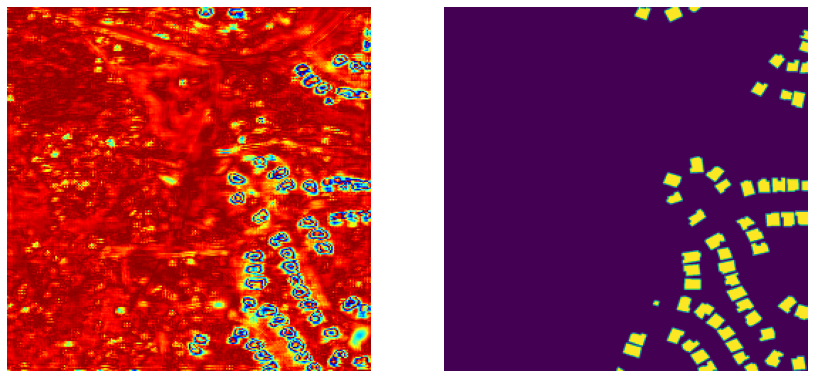

In [263]:
plot_changemap(processed)

In [ ]:
#transform(img1.squeeze(0))

## Test Trained Network

In [ ]:
# track test loss
test_loss = 0.0

model.eval()
# iterate over test data
for batch_i, batch in enumerate(test_loader):

  img1, img2, target = batch

  if train_on_gpu:
    img1, img2, target = img1.to(device), img2.to(device), target.to(device)

    output1, output2 = model(img1, img2)
    loss = criterion(output1, output2, target, device)

    # update test loss 
    test_loss += loss.item()

# average test loss
test_loss = test_loss/len(test_loader)
print('Test Loss: {:.6f}\n'.format(test_loss))

Test Loss: 1.273034



In [ ]:
testiter = iter(test_loader)
img1, img2, target = next(testiter)
img1.shape, img2.shape, target.shape

(torch.Size([64, 3, 256, 256]),
 torch.Size([64, 3, 256, 256]),
 torch.Size([64, 256, 256]))

In [ ]:
#visualize_image([X1_test.squeeze(0), X2_test.squeeze(0), Y_test])

In [ ]:
if train_on_gpu:
  img1, img2, target = img1.cuda(), img2.cuda(), target.cuda()

if train_on_gpu:
  model = model.cuda()

In [ ]:
output1, output2 = model(img1, img2)

In [ ]:
output1.shape, output2.shape

(torch.Size([64, 1, 256, 256]), torch.Size([64, 1, 256, 256]))

In [ ]:
# One Image from batch
X1_test = output1[50,:].squeeze(0)
X2_test = output2[50,:].squeeze(0)
Y_test = target[50,:]
X1_test.shape, X2_test.shape, Y_test.shape

(torch.Size([256, 256]), torch.Size([256, 256]), torch.Size([256, 256]))

In [ ]:
#visualize_image([X1_test, X2_test, Y_test])